#examples vs accuracy
Brute [(1, 19.599), (2, 20.476), (3, 21.129), (4, 20.382), (5, 19.916), (6, 21.082), (7, 20.429), (8, 20.802), (9, 20.336)]
Vlute$_\infty$ [(1, 22.248), (2, 34.748), (3, 38.2), (4, 43.424), (5, 49.114), (6, 51.399), (7, 54.291), (8, 57.649), (9, 58.629)]
Vlute$_{1000}$ [(1, 33.909), (2, 42.957), (3, 48.787), (4, 51.959), (5, 54.711), (6, 56.25), (7, 58.256), (8, 60.448), (9, 61.894)]
Vlute$_{3000}$ [(1, 34.468), (2, 42.817), (3, 47.575), (4, 51.959), (5, 54.897), (6, 56.95), (7, 60.401), (8, 60.541), (9, 62.36)]
Vlute$_{5000}$ [(1, 34.841), (2, 43.004), (3, 48.881), (4, 52.192), (5, 56.25), (6, 56.39), (7, 59.888), (8, 61.707), (9, 63.106)]
Vlute$_{10000}$ [(1, 40.074), (2, 50.294), (3, 52.353), (4, 55.368), (5, 61.471), (6, 61.912), (7, 64.044), (8, 66.765), (9, 69.191)]
Vlute$_{15000}$ [(1, 34.235), (2, 43.424), (3, 48.647), (4, 50.653), (5, 54.944), (6, 56.763), (7, 58.862), (8, 60.494), (9, 61.754)]
Vlute$_{30000}$ [(1, 34.981), (2, 42.491), (3, 48.228), (4, 5

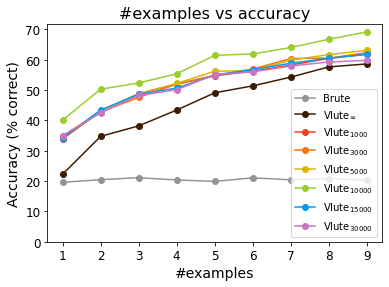

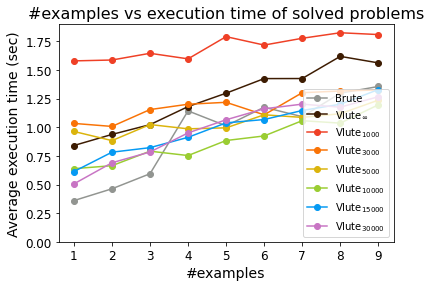

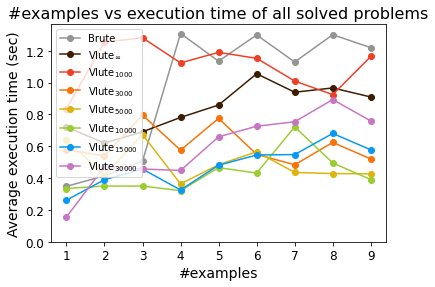

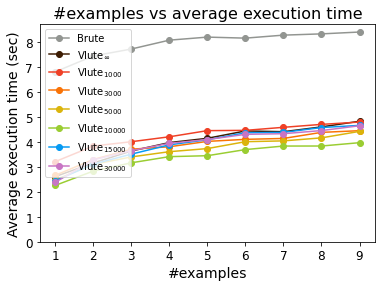

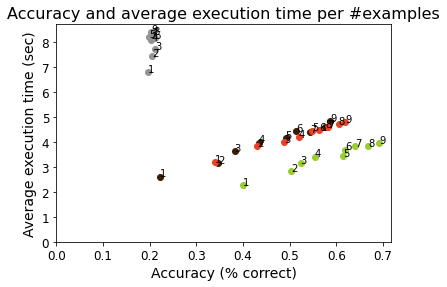

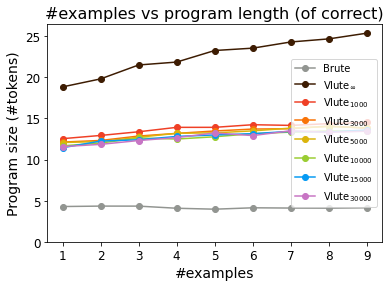

In [2]:
import json
import os
from collections import Callable
import matplotlib.pyplot as plt

class Results:
    def __init__(self, data, colors):
        self.results = [Result(d["file"], d["name"], colors[d["name"]]) for d in data]

    def filter_fields(self, fields: list[str]):
        for r in self.results:
            r.filter_fields(fields)

    def aggregate(self, over: str):
        for r in self.results:
            r.aggregate(over)

    def filter(self, field: str, cond: Callable[[object], bool]):
        for r in self.results:
            r.filter(field, cond)

    def filter_all(self, id_field: str, field: str, cond: Callable[[object], bool]):

        d = {}
        for r in self.results:
            for e in r.results:
                if e[id_field] not in d:
                    d[e[id_field]] = []

                if cond(Result._field_parser(e, field)):
                    d[e[id_field]].append(e)

        l = len(self.results)
        for i in range(0, l):
            self.results[i].results = [v[i] for k, v in d.items() if len(v) == l]

    def plot(self, x: Callable, y: Callable, title: str = "", x_axis: str = "", y_axis: str = ""):
        print(title)

        fig, ax = plt.subplots()

        for r in self.results:
            r.plot(x, y, ax)

        ax.set_ylim(bottom=0)
        plt.xlabel(x_axis, fontsize=14)
        plt.ylabel(y_axis, fontsize=14)
        ax.tick_params(axis='both', which='major', labelsize=12)
        plt.title(title, fontsize=16)

        plt.legend()

    def scatter_plot(self, x: Callable, y: Callable, label: Callable, title: str = "", x_axis: str = "", y_axis: str = ""):
        print(title)

        fig, ax = plt.subplots()

        for r in self.results:
            r.scatter_plot(x, y, label, ax)

        ax.set_ylim(bottom=0)
        ax.set_xlim(left=0)
        plt.xlabel(x_axis, fontsize=14)
        plt.ylabel(y_axis, fontsize=14)
        ax.tick_params(axis='both', which='major', labelsize=12)
        plt.title(title, fontsize=16)

    def histogram(self, x: Callable, bins, title: str = "", x_axis: str = "", y_axis: str = ""):
        for r in self.results:
            r.histogram(x, bins)

    def save(self, question: int, domain: str, name: str):
        folder = "{}/Q{}/graphs/{}".format(os.getcwd(), question, domain)

        if not os.path.exists(folder):
            os.makedirs(folder)

        plt.savefig("{}/{}.pdf".format(folder, name), bbox_inches='tight')

class Result:
    def __init__(self, file_name, name, color):
        self.name = name
        self.color = color

        self.results = []

        with open(file_name, "r") as file:
            for line in file:
                stripped_line = line.strip()
                obj = json.JSONDecoder().decode(stripped_line)
                self.results.append(obj)

    def filter_fields(self, fields: list[str]):
        for i, res in enumerate(self.results):
            self.results[i] = {f: self._field_parser(res, f) for f in fields}

    @staticmethod
    def _field_parser(obj, field):
        if field == "complexity":
            return int(obj["file"].split("/")[1].split("-")[0])

        if field == "file_tuple":
            a = obj["file"].split("/")[1][:-3].split("-")
            return int(a[0]), int(a[1]), int(a[2])

        if field == "correct":
            return 1 if obj["test_cost"] == obj["train_cost"] == 0 else 0

        if field == "zero_train_cost":
            return 1 if obj["train_cost"] == 0 else 0

        if field == "overfitted":
            return 1 if obj["test_cost"] > 0 and obj["train_cost"] == 0 else 0

        if field == "explored_per_sec":
            return obj["number_of_explored_programs"] / obj["execution_time"]

        if field == "average_explored_size_tokens":
            a = obj["explored_per_size_tokens"]
            return sum([a*b for a,b in enumerate(a)]) / sum(a)

        if field == "average_explored_size_sequence":
            a = obj["explored_per_size_sequence"]
            return sum([a*b for a,b in enumerate(a)]) / sum(a)

        if field in obj:
            return obj[field]

        raise Exception()

    def aggregate(self, over: str):
        final = {}

        for res in self.results:
            key = res[over]

            if key not in final:
                final[key] = {"dict": res, "count": 1}
            else:
                final[key]["count"] += 1
                for f in res:
                    final[key]["dict"][f] += res[f]

        for key, value in final.items():
            final[key] = {k: value["dict"][k] / value["count"] for k, v in value["dict"].items()}

        self.results = final

    def filter(self, field: str, cond: Callable[[object], bool]):
        result = []

        for res in self.results:
            if cond(self._field_parser(res, field)):
                result.append(res)

        self.results = result

    def plot(self, x: Callable, y: Callable, ax):
        xs = [x(r) for r in self.results.items()]
        ys = [y(r) for r in self.results.items()]
        yrs =  [y.__round__(3) for y in ys]
        print(self.name, list(zip(xs, yrs)))

        ax.plot(
            xs, ys,
            label=self.name,
            marker='o',
            color=self.color,
        )

    def scatter_plot(self, x: Callable, y: Callable, label: Callable, ax):
        xs = [x(r) for r in self.results.items()]
        ys = [y(r) for r in self.results.items()]
        xrs =  [x.__round__(5) for x in xs]
        yrs =  [y.__round__(5) for y in ys]
        print(self.name, list(zip(xrs, yrs)))

        ax.scatter(
                xs, ys,
                label=self.name,
                marker='o',
                color=self.color,
        )

        labels = [label(r) for r in self.results.items()]

        for x, y, l in zip(xs, ys, labels):
            ax.annotate(l, (x, y))

    def histogram(self, x: Callable, bins, title: str = "", x_axis: str = "", y_axis: str = ""):
        xs = [x(r) for r in self.results]

        plt.hist(
            xs,
            bins=bins,
        )

        plt.xlabel(x_axis)
        plt.ylabel(y_axis)
        plt.title(title)

    def __str__(self):
        return self.results.__str__()

domain = "string"
colors = {
    "Brute": "xkcd:grey",
    "Vlute$_\infty$": "xkcd:chocolate",
    "Vlute$_{1000}$": "xkcd:tomato",
    "Vlute$_{3000}$": "xkcd:orange",
    "Vlute$_{5000}$": "xkcd:gold",
    "Vlute$_{10000}$": "yellowgreen",
    "Vlute$_{15000}$": "xkcd:azure",
    "Vlute$_{30000}$": "xkcd:orchid",
}
data = {
    "robot": [
        {"name": "Brute", "file": "../results/hpc/Q1_robot/Brute.txt"},
        {"name": "Vlute$_\infty$", "file": "../results/hpc/Q1_robot/LNS.txt"},
        {"name": "Vlute$_{1000}$", "file": "../results/hpc/Q1_robot/VDNS_1000.txt"},
        {"name": "Vlute$_{3000}$", "file": "../results/hpc/Q1_robot/VDNS_3000.txt"},
        {"name": "Vlute$_{5000}$", "file": "../results/hpc/Q1_robot/VDNS_5000.txt"},
        {"name": "Vlute$_{10000}$", "file": "../results/hpc/Q1_robot/VDNS_10000.txt"},
        {"name": "Vlute$_{15000}$", "file": "../results/hpc/Q1_robot/VDNS_15000.txt"},
        {"name": "Vlute$_{30000}$", "file": "../results/hpc/Q1_robot/VDNS_30000.txt"},],
    "string": [
        {"name": "Brute", "file": "../results/hpc/Q1_string/Brute_improved.txt"},
        {"name": "Vlute$_\infty$", "file": "../results/hpc/Q1_string/LNS.txt"},
        {"name": "Vlute$_{1000}$", "file": "../results/hpc/Q1_string/VDNS_1000.txt"},
        {"name": "Vlute$_{3000}$", "file": "../results/hpc/Q1_string/VDNS_3000.txt"},
        {"name": "Vlute$_{5000}$", "file": "../results/hpc/Q1_string/VDNS_5000.txt"},
        {"name": "Vlute$_{10000}$", "file": "../results/hpc/Q1_string/VDNS_10000.txt"},
        {"name": "Vlute$_{15000}$", "file": "../results/hpc/Q1_string/VDNS_15000.txt"},
        {"name": "Vlute$_{30000}$", "file": "../results/hpc/Q1_string/VDNS_30000.txt"},],
    "pixel": [
        {"name": "Brute", "file": "../results/hpc/Q1_pixel/Brute.txt"},
        {"name": "Vlute$_\infty$", "file": "../results/hpc/Q1_pixel/LNS.txt"},
        {"name": "Vlute$_{1000}$", "file": "../results/hpc/Q1_pixel/VDNS_1000.txt"},
        {"name": "Vlute$_{3000}$", "file": "../results/hpc/Q1_pixel/VDNS_3000.txt"},
        {"name": "Vlute$_{5000}$", "file": "../results/hpc/Q1_pixel/VDNS_5000.txt"},
        {"name": "Vlute$_{10000}$", "file": "../results/hpc/Q1_pixel/VDNS_10000.txt"},
        {"name": "Vlute$_{15000}$", "file": "../results/hpc/Q1_pixel/VDNS_15000.txt"},
        {"name": "Vlute$_{30000}$", "file": "../results/hpc/Q1_pixel/VDNS_30000.txt"},],
}[domain]
complexity = {
    "robot": "Grid size",
    "string": "#examples",
    "pixel": "Matrix size",
}[domain]

#"""     Complexity vs accuracy

results = Results(data, colors)
results.filter_fields(["complexity", "correct"])
results.aggregate("complexity")
results.plot(
    x=lambda t: t[0],
    y=lambda t: t[1]["correct"]*100,
    title="{} vs accuracy".format(complexity),
    x_axis=complexity,
    y_axis="Accuracy (% correct)"
)
results.save(1, domain, "complexity_vs_accuracy")
#"""

# Complexity vs average execution time (of correct)
results = Results(data, colors)
results.filter("correct", lambda v: v == 1)
#results.filter_all("file", "correct", lambda v: v == 1)
results.filter_fields(["complexity", "execution_time"])
results.aggregate("complexity")
results.plot(
    x=lambda t: t[0],
    y=lambda t: t[1]["execution_time"],
    title="{} vs execution time of solved problems".format(complexity),
    x_axis=complexity,
    y_axis="Average execution time (sec)",
)
results.save(1, domain, "complexity_vs_execution_time_correct")

# Complexity vs average execution time (of all correct)
results = Results(data, colors)
results.filter_all("file", "correct", lambda v: v == 1)
results.filter_fields(["complexity", "execution_time"])
results.aggregate("complexity")
results.plot(
    x=lambda t: t[0],
    y=lambda t: t[1]["execution_time"],
    title="{} vs execution time of all solved problems".format(complexity),
    x_axis=complexity,
    y_axis="Average execution time (sec)",
)
results.save(1, domain, "complexity_vs_execution_time_all_correct")

# Complexity vs average execution time (overall)
results = Results(data, colors)
results.filter_fields(["complexity", "execution_time"])
print(len(results.results[0].results))
results.aggregate("complexity")
results.plot(
    x=lambda t: t[0],
    y=lambda t: t[1]["execution_time"],
    title="{} vs average execution time".format(complexity),
    x_axis=complexity,
    y_axis="Average execution time (sec)",
)
results.save(1 ,domain, "complexity_vs_execution_time_overal")
#"""

# Per complexity (execution time, accuracy)
results = Results([d for d in data if d["name"] in {"Brute", "Vlute$_\infty$", "Vlute$_{1000}$", "Vlute$_{10000}$"}], colors)
results.filter_fields(["complexity", "execution_time", "correct"])
results.aggregate("complexity")
results.scatter_plot(
    x=lambda t: t[1]["correct"],
    y=lambda t: t[1]["execution_time"],
    label=lambda t: int(t[1]["complexity"]),
    title="Accuracy and average execution time per {}".format(complexity.lower()),
    x_axis="Accuracy (% correct)",
    y_axis="Average execution time (sec)",
)
results.save(1, domain, "exe_time_and_accuracy_per_complexity")

# Complexity vs program length (of correct)
results = Results(data, colors)
results.filter("correct", lambda v: v == 1)
#results.filter_all("file", "correct", lambda v: v == 1)
results.filter_fields(["complexity", "program_length"])
results.aggregate("complexity")
results.plot(
    x=lambda t: t[0],
    y=lambda t: t[1]["program_length"],
    title="{} vs program length (of correct)".format(complexity),
    x_axis=complexity,
    y_axis="Program size (#tokens)",
)
results.save(1, domain, "complexity_vs_program_length_of_correct")